In [2]:
import pandas as pd 
import os, glob
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [112]:
btc = pd.concat((pd.read_csv(f, engine="python") for f in glob.glob(r"gemini_BTCUSD_20[12][67890]*.csv")), ignore_index=True)
eth = pd.concat((pd.read_csv(f, engine="python") for f in glob.glob(r"gemini_ETHUSD_20[12][67890]*.csv")), ignore_index=True)

btc["Date"] = pd.to_datetime(btc["Date"], format="%Y-%m-%d %H:%M:%S")
eth["Date"] = pd.to_datetime(eth["Date"], format="%Y-%m-%d %H:%M:%S")

def compute_corr(time_window, eth, btc):
    ether = eth.resample(str(time_window) + "H", on="Date").agg({"Open": "first", "Close": "last", "Volume": np.sum, "High": np.max, "Low": np.min})
    bitcoin = btc.resample(str(time_window) + "H", on="Date").agg({"Open": "first", "Close": "last", "Volume": np.sum, "High": np.max, "Low": np.min})

    ether = eth.add_prefix("eth_")
    bitcoin = btc.add_prefix("btc_")

    df = pd.concat((bitcoin, ether), axis=1, join="inner")
    df["eth_diff"] = (df["eth_Close"] - df["eth_Open"])/df["eth_Close"]
    df["btc_diff"] = (df["btc_Close"] - df["btc_Open"])/df["btc_Close"]
    return df["eth_diff"].corr(df["btc_diff"].shift(1))

windows = [3, 5, 30, 60, 180, 240*60, 300, 360, 480*60, 60*8, 60*12, 60*24, 60*36, 60*48,
          60*72, 60*24*5, 60*24*14, 600*60, 60*24*21, 60*24*30]
windows = list(map(lambda x: x/60, windows))
windows = sorted(windows)
correlations = [compute_corr(x, eth, btc) for x in windows]

In [101]:
btc = pd.concat((pd.read_csv(f, engine="python") for f in glob.glob(r"gemini_BTCUSD_20[12][67890]*.csv")), ignore_index=True)
eth = pd.concat((pd.read_csv(f, engine="python") for f in glob.glob(r"gemini_ETHUSD_20[12][67890]*.csv")), ignore_index=True)

btc["Date"] = pd.to_datetime(btc["Date"], format="%Y-%m-%d %H:%M:%S")
eth["Date"] = pd.to_datetime(eth["Date"], format="%Y-%m-%d %H:%M:%S")

eth = eth.resample("1H", on="Date").agg({"Open": "first", "Close": "last", "Volume": np.sum, "High": np.max, "Low": np.min})
btc = btc.resample("1H", on="Date").agg({"Open": "first", "Close": "last", "Volume": np.sum, "High": np.max, "Low": np.min})

eth = eth.add_prefix("eth_")
btc = btc.add_prefix("btc_")

df = pd.concat((btc, eth), axis=1, join="inner")
df = df.dropna()
df["eth_diff"] = (df["eth_Close"] - df["eth_Open"])/df["eth_Close"]
df["btc_diff"] = (df["btc_Close"] - df["btc_Open"])/df["btc_Close"]

In [102]:
eth.head()

eth_Open  eth_Close  eth_Volume  eth_High  eth_Low
Date                                                                   
2017-01-01 00:00:00      8.28       8.28    0.000000      8.28     8.28
2017-01-01 01:00:00      8.28       8.26    9.544444      8.28     8.26
2017-01-01 02:00:00      8.26       8.54    8.760301      8.54     8.26
2017-01-01 03:00:00      8.54       8.54    0.000000      8.54     8.54
2017-01-01 04:00:00      8.54       8.51    3.590000      8.54     8.51

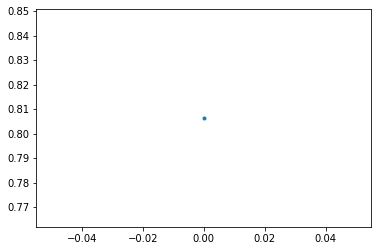

In [103]:
plt.plot(df["btc_Close"].corr(df["eth_Close"]), ".")
plt.show()

Text(0, 0.5, 'R Value')

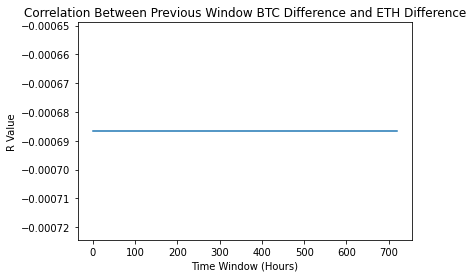

In [113]:
plt.plot(windows, correlations)
plt.title("Correlation Between Previous Window BTC Difference and ETH Difference")
plt.xlabel("Time Window (Hours)")
plt.ylabel("R Value")

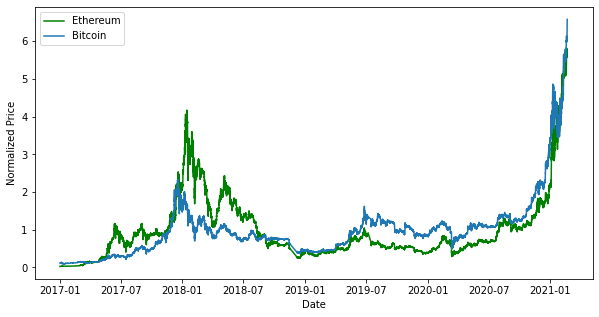

In [105]:
df["eth_diff"] = df["eth_Close"]/df["eth_Close"].mean()
df["btc_diff"] = df["btc_Close"]/df["btc_Close"].mean()

plt.plot(df["eth_diff"], "green", label="Ethereum")
plt.plot(df["btc_diff"], label="Bitcoin")
plt.ylabel("Normalized Price")
plt.xlabel("Date")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 5)

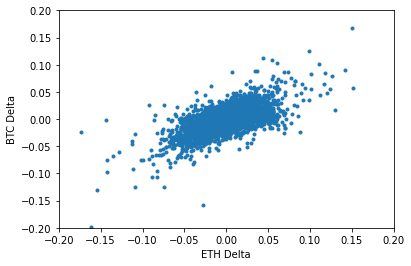

0.6819874948896337

In [109]:
df["eth_diff"] = (df["eth_Close"] - df["eth_Open"])/df["eth_Close"]
df["btc_diff"] = (df["btc_Close"] - df["btc_Open"])/df["btc_Close"]

plt.plot(df["eth_diff"], df["btc_diff"], ".")
plt.xlim([-.2, .2])
plt.ylim([-.2, .2])
plt.xlabel("ETH Delta")
plt.ylabel("BTC Delta")
plt.show()
df["eth_diff"].corr(df["btc_diff"])

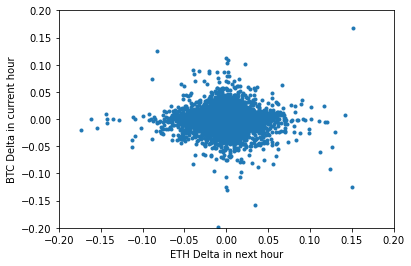

-0.03002919824664096

In [110]:
plt.plot(df["eth_diff"], df["btc_diff"].shift(1), ".")
plt.xlim([-.2, .2])
plt.ylim([-.2, .2])
plt.xlabel("ETH Delta in next hour")
plt.ylabel("BTC Delta in current hour")
plt.show()
df["eth_diff"].corr(df["btc_diff"].shift(1))